### Projeto:
Obter um controlador para a planta:

$ \Large G = \frac{0.1942s + 0.08413}{s^2 + 61.79 s + 184} $

Requisitos PID: \
$T_s<2s$ \
$\zeta >0.5$



In [ ]:
import sympy
from sympy import I, init_printing
import numpy as np

init_printing()
s = sympy.symbols('s')
beta2, beta1, beta0, alpha0 = sympy.symbols('\\beta_2,\\beta_1,\\beta_0,\\alpha_0')

### Solução
Ordem do controlador: $m = n = 2 $ 

Controlador: $$ \Large C = \frac{\beta_2 s^2 + \beta_1 s + \beta_0}{s(s+\alpha_0)}$$

Planta $G(s):$ $$ \Large G(s) = k\frac{s+a}{(s+b)(s+c)}$$

Passos: Obter os polinômios característicos $\phi_d$ (desejado) e $\phi_c$ (controlador-generico) e por fim igualá-los para resolver o sistema dos coeficientes do pid.

In [ ]:
k = 0.001667
a = 0.433
b = 9* np.pi
c = 1.7*np.pi

n_G = 0.001667* (s+a)
d_G = (s+b)*(s+c)

n_C = beta2*s**2+beta1*s+beta0
d_C = (s+a)*s

phi_c = n_G*n_C + d_C*d_G
phi_c = phi_c.expand().collect(s)
phi_c

In [ ]:
"""Neste bloco será feita a alocados dos polos, seguindo as regras de projeto """

ok = []
ook =[]
for wn in np.arange(2, 5, 0.2):
    for i in np.arange(0.5, 1, 0.01):
        csi= i
        p = 5* wn * csi
        m1 = -csi*wn + wn*np.sqrt(1-csi**2)*I
        m2 = -csi*wn - wn*np.sqrt(1-csi**2)*I
        # m1= (-0.866 + 0.500*I)*wn
        # m2 = (-0.866 - 0.500*I)*wn    

        phi_d = (s+ p)**2*(s -m1)*(s - m2)
        phi_d = phi_d.expand().collect(s)
        sol = sympy.solve(phi_d - phi_c,(beta2, beta1, beta0, alpha0))
        try:
            if list(sol.values())[0]:
                ok.append(csi)
                ook.append(wn)
        except Exception as e:
            continue
    if ok != []:
        break
  



In [ ]:
ook

In [ ]:

# coefs = []
# for i in sol.values():
#     coefs.append(i)

# FT = (coefs[3]*s**2+coefs[2]*s+coefs[1])/((s+coefs[0])*s)
# print(FT)
best = 100000000
a0 = []
b2 = []
for i in ok:
    csi= i
    p = 5* wn * csi
    m1 = -csi*wn + wn*np.sqrt(1-csi**2)*I
    m2 = -csi*wn - wn*np.sqrt(1-csi**2)*I
    # m1= (-0.866 + 0.500*I)*wn
    # m2 = (-0.866 - 0.500*I)*wn    

    phi_d = (s+ p)**2*(s -m1)*(s - m2)
    phi_d = phi_d.expand().collect(s)
    sol = sympy.solve(phi_d - phi_c,(beta2, beta1, beta0, alpha0))
    a0.append(list(sol.values())[3])
    b2.append(list(sol.values())[0])

for i in a0:
    if i<0:
        i =9999
for i in b2:
    if i<0:
        i =9999

min_a0 = min(a0)
min_b2 = min(b2)
print(min_a0,min_b2)

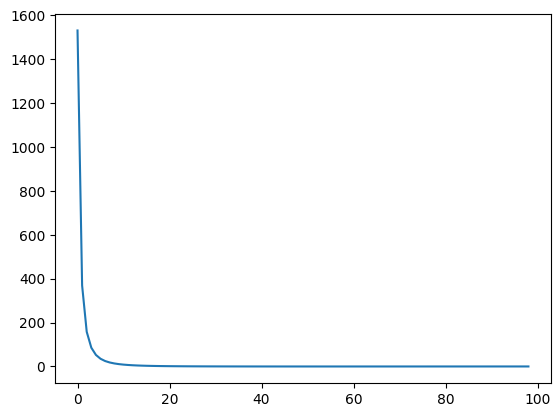

In [99]:
import control.matlab as cl
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("degrau_processado.csv")
t= np.array(df['t'].values)
Io= (np.array((df['Io'].values)) - 1.36)*-1

s = cl.tf('s')

best = 99999999
bests = []
Kz_dic = {}
j=0
for i in np.arange(0.001,0.10,0.001):
    z = i*2*np.pi
    K = 249.2/z
    g = K*(s+z)/((s+4.5*2*np.pi)*(s+0.85*2*np.pi))
    yg, t =cl.step(g * 0.194, t)
    err = np.mean((yg - Io)** 2)
    bests.append(err)

    Kz_dic[j] = [K ,z]
    
    j +=1
    if err < best:
        best = err

plt.plot(bests)


In [106]:
best_idx = bests.index(min(bests))
Kb , zb = Kz_dic[best_idx]
best_idx


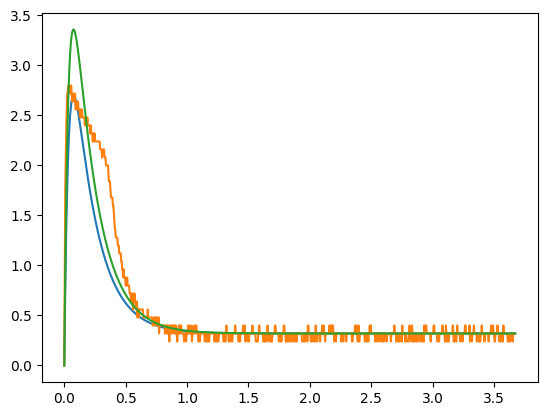

In [120]:
z = 0.07*2*np.pi
K = 249/z
g = K*(s+z)/((s+4.5*2*np.pi)*(s+0.85*2*np.pi))
yg, t =cl.step(g * 0.194, t)

gb = Kb*(s+zb)/((s+4.5*2*np.pi)*(s+0.85*2*np.pi))
ygb, t =cl.step(gb * 0.194, t)

plt.plot(t,yg)
plt.plot(t,Io)
plt.plot(t,ygb)
K, z

In [ ]:
Kb,zb